In [1]:
%load_ext autoreload
%autoreload 2

import scipy.stats as stats
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from helpers import *

data_folder = 'DATA/'

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_

In [2]:
# load data
movie_data = pd.read_csv(data_folder + 'movie_data_final.csv')
character_data = pd.read_csv(data_folder + 'characters_data.csv')
#movie_data = pd.read_csv(data_folder + 'movie_data.csv')
#main_char_data = pd.read_csv(data_folder + 'movies_after_main_char_analysis.csv')

C:\Users\lucil\AppData\Local\Temp\ipykernel_26860\222872268.py:3: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  character_data = pd.read_csv(data_folder + 'characters_data.csv')


In [3]:
movie_data

,IMDB_ID,wikipedia_ID,freebase_ID,runtime,name,release_date,genre,plot_summary,box_office_revenue,popularity,decade,main characters,main character genders
0,tt0228333,975900.0,/m/03vyhn,98.0,Ghosts of Mars,2001.0,"['Thriller', 'Supernatural', 'Action', 'Advent...","Set in the second half of the 22nd century, th...",14010832.0,0.031534,2000.0,NaN,NaN
1,tt0245916,3196793.0,/m/08yl5d,95.0,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,"['Mystery', 'Drama', 'Biography']",NaN,NaN,NaN,2000.0,NaN,NaN
2,tt0002894,13696889.0,/m/03cfc81,35.0,The Gangsters,1913.0,"['Indie', 'Comedy']",NaN,NaN,NaN,1910.0,NaN,NaN
3,tt0029852,10408933.0,/m/02qc0j7,106.0,Alexander's Ragtime Band,1938.0,"['Comedy', 'Musical']",NaN,3600000.0,NaN,1930.0,NaN,NaN
4,tt0021335,175026.0,/m/017n1p,86.0,Sarah and Son,1930.0,['Drama'],NaN,NaN,NaN,1930.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53985,tt9913288,NaN,NaN,NaN,Letters,2020.0,['Drama'],"[""Charlie Porter is an ordinary man. He leads ...",NaN,NaN,2020.0,['charlie porter'],['M']
53986,tt9914522,NaN,NaN,NaN,The Holden Family Plan,2019.0,['Drama'],"[""When Mackenzie Holden's sister and brother i...",NaN,NaN,2010.0,"['mackenzie holden', 'evan', 'jade']","['F', 'M', 'F']"
53987,tt9914582,NaN,NaN,NaN,However Long,2019.0,['Documentary'],['Documentary following four women with incura...,NaN,NaN,2010.0,NaN,NaN
53988,tt9914642,NaN,NaN,NaN,Albatross,2017.0,['Documentary'],"[""ALBATROSS is a powerful visual journey into ...",NaN,NaN,2010.0,NaN,NaN


In [4]:
movie_data['genre'] = movie_data['genre'].apply(ast.literal_eval)

In [5]:
# ADD THIS AT THE END OF DATA CREATION NOTEBOOK
#movie_data_final = pd.merge(movie_data, main_char_data[['IMDB_ID', 'main characters', 'main character genders']], how='left', on='IMDB_ID')
#movie_data_final
#movie_data_final.to_csv(data_folder + 'movie_data_final.csv', index=False)
#movie_data_final.to_pickle(data_folder + 'movie_data_final.pickle')

# Clustering
The idea is to create a dataframe for each movie with the characteristics extracted from the data that could make them more or less stereotypical, namely:
- proportion of women in the movie
- female/male ratio of main character
- difference between mean age of men and of women

The clustering algorithm should thus group movies together that have similar level of gender stereotypes. We can then analyse the movies in these clusters to see if movie some genres, decades or popularity scores are more present in stereotypical movies. We can also analyse how the number of stereotypical movies evolve throughout the decades.

In [6]:
# remove character with unknown genders
character_data = character_data.dropna(subset='actor_gender')

### Proportion of female actress

In [7]:
# compute proportion of female actress per movie
characters_per_movie = character_data.groupby('IMDB_ID')
proportion_female = characters_per_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

In [8]:
# create a dataframe on which we will perform clustering
stereotype_df = pd.DataFrame({'IMDB_ID': proportion_female.index, 'proportion_female': proportion_female.values})

### Proportion of female main character

In [9]:
movie_data = movie_data.dropna(subset='main character genders')
# compute the proportion of female main character for each movie
main_characters_ratio = movie_data['main character genders'].apply(calculate_gender_ratio)
movie_data['proportion_female_main_char'] = main_characters_ratio

C:\Users\lucil\AppData\Local\Temp\ipykernel_26860\3129871300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['proportion_female_main_char'] = main_characters_ratio


In [10]:
# merge with clustering dataframe and keep only movies with known main character proportions
stereotype_df = pd.merge(stereotype_df, movie_data[['IMDB_ID', 'proportion_female_main_char', 'decade']], on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='proportion_female_main_char')

In [11]:
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,decade
12,tt0002143,0.800000,0.000000,1910.0
52,tt0002509,0.600000,0.500000,1910.0
66,tt0002618,0.166667,0.666667,1910.0
70,tt0002663,0.250000,0.500000,1910.0
80,tt0002755,0.444444,0.000000,1910.0
...,...,...,...,...
46921,tt9907782,0.500000,0.000000,2020.0
46922,tt9908448,0.600000,1.000000,2010.0
46923,tt9908592,0.666667,0.000000,2010.0
46927,tt9913288,0.000000,0.000000,2020.0


### Age difference
Here we compute the difference of the mean age between men and women. This is added to the clustering data set since movies with much older men than women could be considered as more stereotypical. A negative value in the difference of means indicates that men are older than women.

In [12]:
mean_ages = compute_difference_mean_ages(character_data)
stereotype_df = pd.merge(stereotype_df, mean_ages[['IMDB_ID', 'difference_mean_ages']], on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='difference_mean_ages')
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,decade,difference_mean_ages
0,tt0002143,0.800000,0.000000,1910.0,-8.000000
1,tt0002509,0.600000,0.500000,1910.0,-0.333333
2,tt0002618,0.166667,0.666667,1910.0,-7.400000
3,tt0002663,0.250000,0.500000,1910.0,-8.333333
4,tt0002755,0.444444,0.000000,1910.0,-9.050000
...,...,...,...,...,...
12491,tt9898858,0.500000,0.333333,2020.0,-4.000000
12492,tt9899726,0.500000,1.000000,2010.0,-21.000000
12495,tt9904648,0.500000,0.333333,2020.0,-3.000000
12496,tt9907782,0.500000,0.000000,2020.0,-9.500000


### Clustering with K-means
Before doing the clustering, we need to pre-process the data. Proportions of female and of female main character are already normalised. We thus only need to normalise the age difference. We also identify the optimal number of clusters.

In [13]:
# prepare the data for clustering
clustering_df = stereotype_df.drop(columns=['IMDB_ID', 'decade'])
clustering_df['difference_mean_ages'] = MinMaxScaler().fit_transform(clustering_df['difference_mean_ages'].values.reshape(-1, 1))

To find the optimal value of k for the clustering, we plot the sum squared error (sse) of the clustering for different k. The graph should show an "elbow", i.e. a k for which further increasing k does not lead to a decrease as important as before of the sse.

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


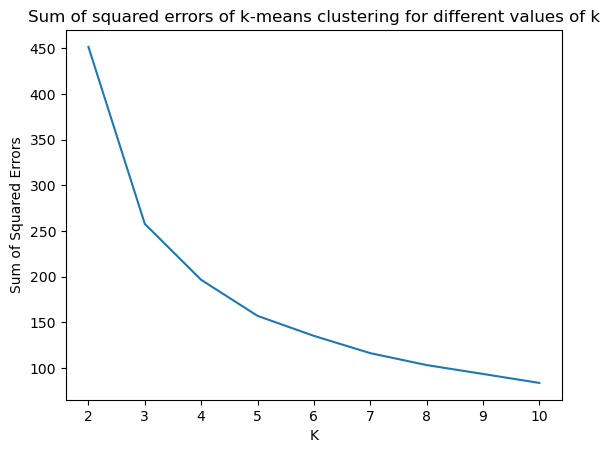

In [14]:
plot_sse(clustering_df)

We see on the plot above that the elbow of the curve is located at n=3. However, one could also see a second elbow at k=5. We will thus perform a second analysis to determine the appropriate k. We will choose the k with the highest silhouette score.

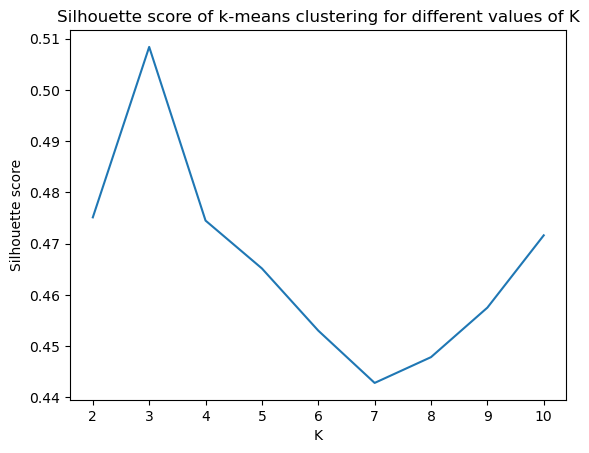

In [15]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10, n_init=10).fit_predict(clustering_df)
    # Get the Silhouette score
    score = silhouette_score(clustering_df, labels)
    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title('Silhouette score of k-means clustering for different values of K')
plt.show()

We see on the plot above that the K with the highest silhouette score is 3. This confirmed what we observed using the elbow method and we will thus perform k-means clustering with k=3.

In [16]:
# run k-means
kmean = KMeans(n_clusters=3, random_state=0, n_init=10).fit(clustering_df)

### Visualising the clusters

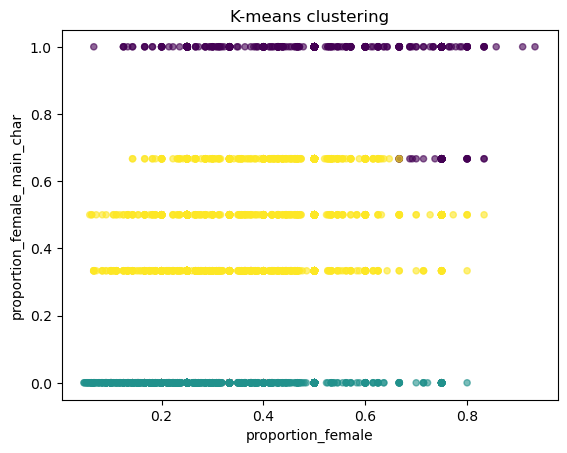

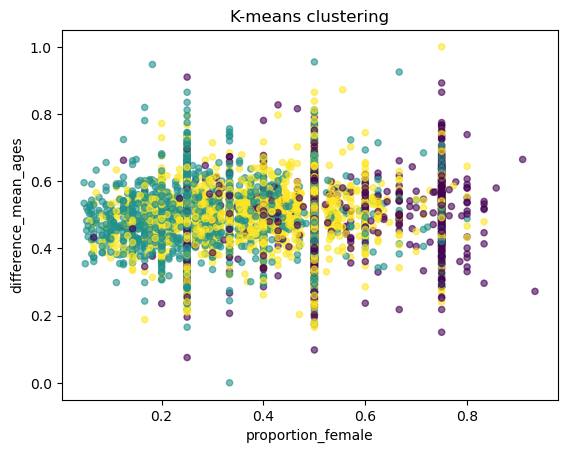

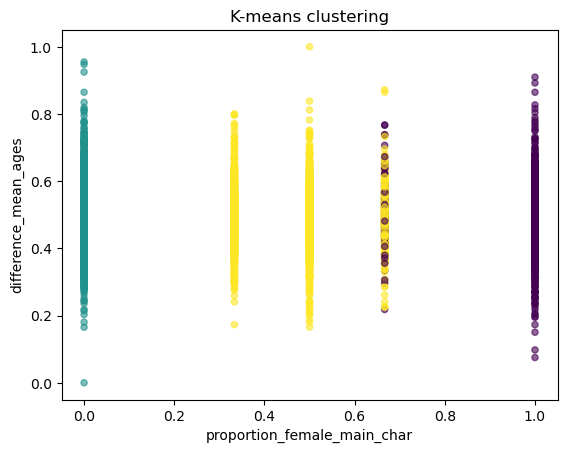

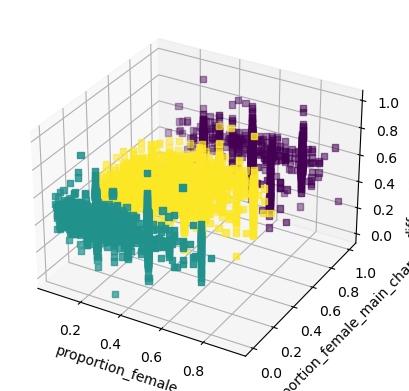

In [17]:
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'proportion_female_main_char'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'difference_mean_ages'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female_main_char', 'difference_mean_ages'])
plot_kmeans_3d(clustering_df, kmean.labels_, ['proportion_female', 'proportion_female_main_char', 'difference_mean_ages'])

### Analysing the clusters

We will first look at the movies in each clusters to see if they were indeed clustered according to which extant they have a stereotypical depiction of women.

In [18]:
# add k-means label to the dataset that also contains IMDB IDs
stereotype_df['cluster_index'] = kmean.labels_
stereotype_df.drop(columns=['IMDB_ID', 'decade']).groupby('cluster_index').mean()

,proportion_female,proportion_female_main_char,difference_mean_ages
cluster_index,,,
0,0.531609,0.977797,-6.755061
1,0.321196,0.000000,-8.079249
2,0.398346,0.461334,-7.196680


We see that cluster 0 seems to be the less stereotypical with a higher proportion of women in the cast and as main character and a smaller difference of means than the other clusters. Cluster 1 seems to be the most stereotypical. Indeed, we observe that movies in this cluster never have women as main characters and that they have a low proportion of actresses. Additionally, the difference of age between women and men is also higher than for movies in the other clusters. Cluster 2 seems to be located in between clusters 0 and 1 with a moderate amount of actresses both in general and playing main characters and an age difference bigger than cluster 0 but smaller than cluster 1. Since in the current analysis we are mostly interested in extremes (stereotypical and non-stereotypical movies), we will discard cluster 2 and focus on cluster 0 and 1.

In [19]:
# select most and least stereotypical movies according to the clustering
not_stereotypical_ids = stereotype_df[(stereotype_df['cluster_index'] == 0)]['IMDB_ID']
not_stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(not_stereotypical_ids)]
stereotypical_ids = stereotype_df[(stereotype_df['cluster_index'] == 1)]['IMDB_ID']
stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(stereotypical_ids)]

### A) Number of movies
As a first analysis we will have a look at the percentage of movies that belong to each category

In [20]:
not_stereo_percent = not_stereotypical_movies.shape[0]*100/stereotype_df.shape[0]
stereo_percent = stereotypical_movies.shape[0]*100/stereotype_df.shape[0]
print(f'{not_stereo_percent:.2f}% of movies do not represent women in a stereotypical way')
print(f'{stereo_percent:.2f}% of movies represent women in a stereotypical way')
print(f'{100-not_stereo_percent-stereo_percent:.2f}% were not classified into one of these categories')

16.74% of movies do not represent women in a stereotypical way
37.21% of movies represent women in a stereotypical way
46.05% were not classified into one of these categories


We see already that movies that clearly represent women in a non-stereotypical ways are in minority. Of course these percentages are computed on only a subset of our movies for which we were able to compute all the variables necessary for the clustering, but here we make the assumption that this subset is representative of the whole set of US movies.

### B) Popularity
Now we will analyse whether more popular movies tend to be more or less stereotypical. We can do this by using a t-test on the distribution of popularity for both datasets. The null hypothesis is "stereotypical and non-stereotypical movies have the same average popularity".

In [21]:
ttest_results = stats.ttest_ind(stereotypical_movies['popularity'].dropna(), not_stereotypical_movies['popularity'].dropna())
print(f't-statistics = {ttest_results.statistic}, p value = {ttest_results.pvalue}')

t-statistics = 1.2158898915315504, p value = 0.22444449661983146


The p-value is higher than 0.05. We thus cannot reject the null hypothesis and make any conclusions. This might be due to the fact that we have very little data on the popularity of movies and would need more to make any meaningful conclusions.

### C) Genres
The aim of this part is to explore which genre stereotypical and non-stereotypical movies belong to. We will start by looking at the genres present in our two categories of movies.

In [22]:
not_stereotypical_genre_counts = not_stereotypical_movies['genre'].explode().value_counts()
stereotypical_genre_counts = stereotypical_movies['genre'].explode().value_counts()

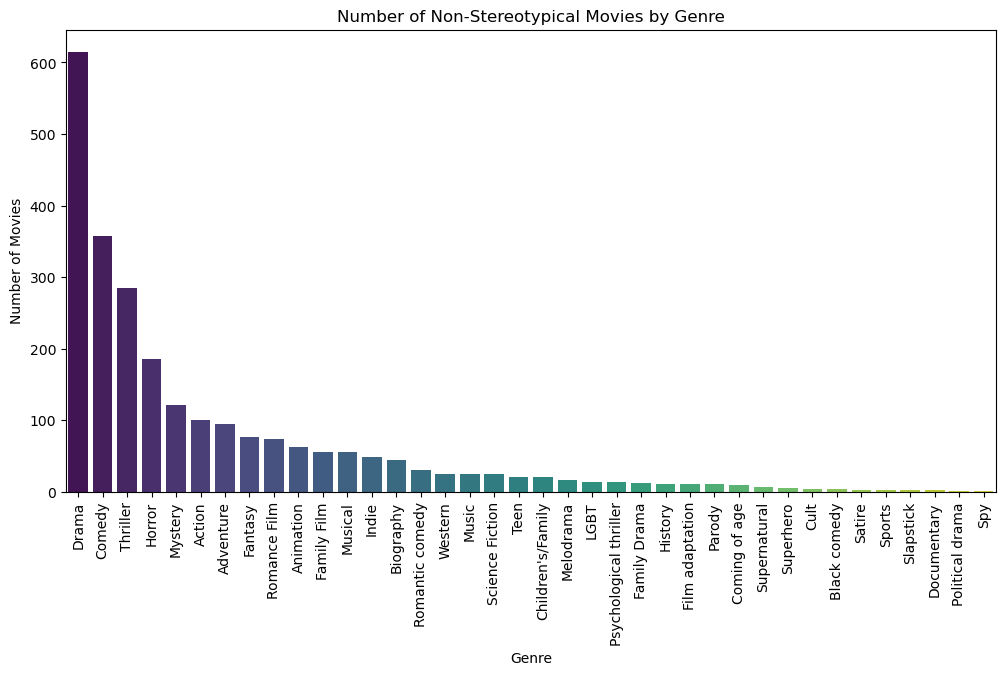

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x=not_stereotypical_genre_counts.index, y=not_stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Non-Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

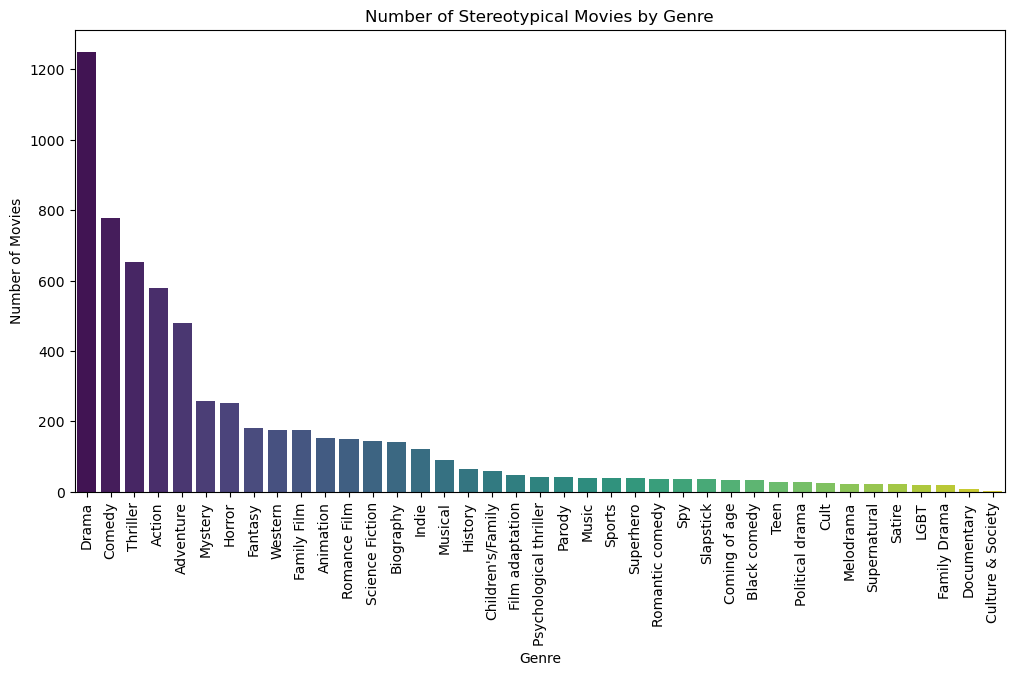

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x=stereotypical_genre_counts.index, y=stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

We see that a variety of genres are present in the two categories. Let's see how different the proportions of genre in each category is. Since the number of movies is different for stereotypical and non-stereotypical movies, we first normalise by the total number of movies for each category and then study the difference of this ratio.

In [25]:
# let's have a look at the difference
# first transform counts into percentages
percentage_stereo = stereotypical_genre_counts/stereotypical_movies.shape[0]
percentage_not_stereo = not_stereotypical_genre_counts/not_stereotypical_movies.shape[0]
# do the difference
percentage_diff = percentage_not_stereo - percentage_stereo
# if one genre is not present in one of the 2 categories we set its percentage to 0 in this category instead of nan
for genre in percentage_diff[percentage_diff.isna()].index:
    if stereotypical_genre_counts[genre] !=0:
        percentage_diff[genre] = -stereotypical_genre_counts[genre]/stereotypical_movies.shape[0]
    elif not_stereotypical_genre_counts[genre] != 0:
        percentage_diff[genre] = not_stereotypical_genre_counts[genre]/not_stereotypical_movies.shape[0]

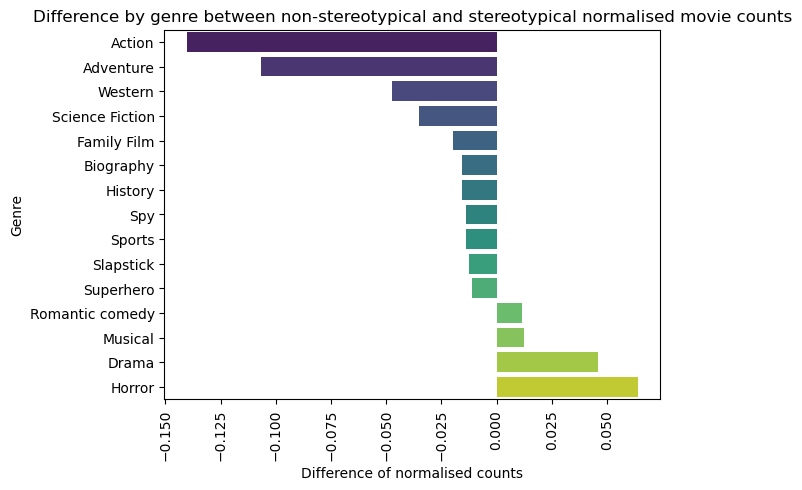

In [26]:
# sort in increasing order to plot
percentage_diff = percentage_diff.sort_values()
# only keep genres that have at least 1% difference between the 2 categories
percentage_diff_to_plot = percentage_diff[(percentage_diff.values > 0.01) | (percentage_diff.values < -0.01)]
# plot
sns.barplot(x=percentage_diff_to_plot, y=percentage_diff_to_plot.index , palette='viridis', orient='h')
#sns.barplot(y=percentage_diff_to_plot, x=percentage_diff_to_plot.index , palette='viridis', orient='v')
plt.xticks(rotation=90)
plt.title('Difference by genre between non-stereotypical and stereotypical normalised movie counts')
plt.xlabel('Difference of normalised counts')
plt.ylabel('Genre')
plt.show()

The plot above represents the difference of ratio between the not stereotypical and the stereotypical movies. If the difference is negative it means that there is a higher proportion of this movie genre in the stereotypical movies. Inversely, if the difference is positive, it means that there is a higher proportion of this movie genre in the non-stereotypical movies. We thresholded the graph to only see movies that had a difference bigger than 0.01. We assumed that a smaller difference was too small to assume a real difference between the clusters.

Action movies are the ones that have the most difference between our two categories. The proportion of action movies in our stereotypical category is ~14% more than the one in our non-stereotypical category. We see that there are quite a few other categories that have a difference of proportion of more than 1%. The top 5 genre that appear more in the stereotypical movies are:
1. Action
2. Adventure
3. Western
4. Science Fiction
5. Family Film

Interestingly, we have less movie genres that are more present in the non-stereotypical group than in the other. We have only the 4 following categories:
1. Horror
2. Drama
3. Musical
4. Romantic comedy

Here we see one caveat of our method. Indeed, romantic comedies appear in the movies that have a non-stereotypical representation of women. It is however well-known that in general in romantic comedies women are solely love interests and are thus portrayed stereotypically. This highlights the need to not only look at the proportion of actress, the proportion of women character and the age difference but consider other factors. More precisely it would be interesting to look at the vocabulary linked to female and male actress in general and also in these specific genres to see if they really are less stereotypical.

Another thing that is important to note is that here we took the data across all years. Since we have much more movies in the decades 2010-2020, these years are overrepresented in the previous analysis.

### D) Decades
After these first analyses, we will now look at how the the stereotypical and not stereotypical movies evolve through the decades.

Let's first simply have a look at whether the distribution of decades throughout the stereotypical and not stereotypical datasets differ. To do so, we perform a t-test with the null hypothesis "stereotypical movies have the same mean release decade as non-stereotypical ones".

In [27]:
ttest_results = stats.ttest_ind(stereotypical_movies['decade'].dropna(), not_stereotypical_movies['decade'].dropna())
print(f't-statistics = {ttest_results.statistic}, p value = {ttest_results.pvalue}')

t-statistics = -7.045176023921748, p value = 2.2015444435497535e-12


The results of the t-test indicate that we can reject the null hypothesis at a significance level of 0.05. We can thus conclude that there is a difference in mean release decade between stereotypical and non-stereotypical movies. Moreover, since the t-statistics is negative, we can conclude that stereotypical movies tend to have been release in earlier decades than non-stereotypical movies. This is coherent with our original hypothesis that was that as women's rights progresses, their representation in the cinema industry evolves to be less biased.

To further explore the link between the decades and the extent of gender representation in movies, we will have a look at the proportion of movies released that had a stereotypical representation of women per decade.

In [28]:
# Group movies by decade
stereo_movie_by_decade = stereotypical_movies.groupby(stereotypical_movies['decade'])
not_stereo_movie_by_decade = not_stereotypical_movies.groupby(not_stereotypical_movies['decade'])
total_movies = movie_data[movie_data['IMDB_ID'].isin(stereotype_df['IMDB_ID'])]
total_movies_per_year = total_movies.groupby(total_movies['decade'])

# compute fraction of total movies per decade for each category
fraction_stereo_movies_decade = stereo_movie_by_decade.size()/total_movies_per_year.size()
fraction_not_stereo_movies_decade = not_stereo_movie_by_decade.size()/total_movies_per_year.size()
others = 1-fraction_not_stereo_movies_decade-fraction_stereo_movies_decade

# compute confidence interval using bootstrap
lower_stereo, upper_stereo, lower_not_stereo, upper_not_stereo = bootstrap_ci_stereotypical_movies(stereotype_df)

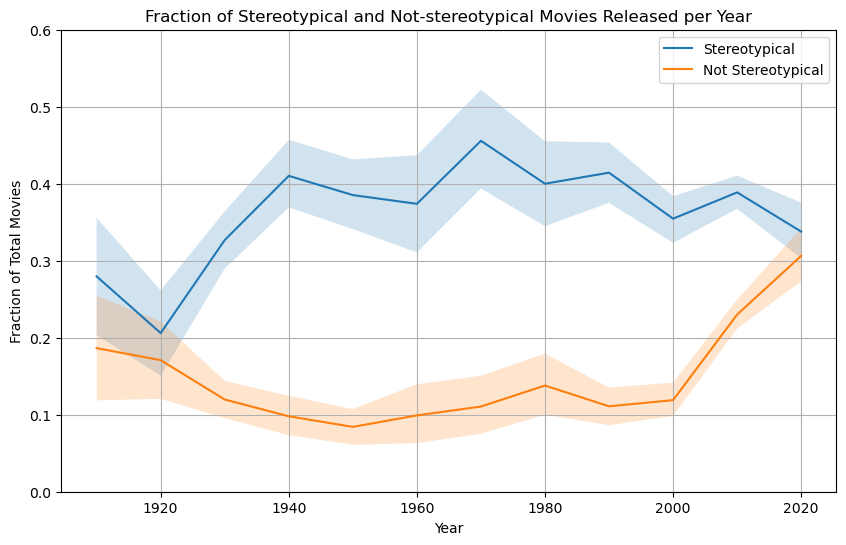

In [29]:
# Plot
# Interpolate values to align with timeline

plt.figure(figsize=(10, 6))
fraction_stereo_movies_decade.plot(kind='line', label='Stereotypical')
fraction_not_stereo_movies_decade.plot(kind='line', label='Not Stereotypical')

plt.fill_between(fraction_stereo_movies_decade.index, lower_stereo, upper_stereo, alpha=0.2)
plt.fill_between(fraction_not_stereo_movies_decade.index, lower_not_stereo, upper_not_stereo, alpha=0.2)

plt.title('Fraction of Stereotypical and Not-stereotypical Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Fraction of Total Movies')
plt.legend()
plt.grid(True)
plt.ylim(0,0.6)
plt.show()

We see that before 1920 the confidence interval intercepts and we thus cannot reach any conclusions. However, we see that from 1920 up to 2020 there seem to always have been a bigger percentage of movies produced that had a stereotypical depiction of women. From 1920 to 1940 we see an increase in the stereotypical movies produced. In the 70s the proportion of stereotypical movies was almost 50% and is the highest in the years analysed. However, it is important to note that the confidence intervals are quite big, we thus cannot be sure that the trend observed from 1940 to 2020 is accurate and the number of stereotypical movies during this period could also just have stayed the same.

Interestingly, the proportion of non-stereotypical movies was relatively stable throughout the decades until 2000. From 2000 to 2020 we see a strong increase of the proportion of movies with a non-stereotypical depiction of women to reach approximately the same percentage than stereotypical movies.

In conclusion, we can see that the depiction of women evolved through time. Indeed, even though the proportion of stereotypical movies increased in the early 20th century and then stayed at a relatively high level, the proportion of movies having representation of women going against stereotypes increased drastically from 2000 to 2020.

Finally, we will try to see whether any of these could be explained by the events in our timeline.

In [30]:
timeline = pd.read_csv(data_folder + 'timeline.csv')

Let's see which events could have prompted the increase of non-stereotypical movies in 2000 and later. Since movies take a lot of time to be made, we can assume that events from the 1990s and later could influence this increase and that events after 2018 (5 years ago) did not have enough time to really affect the cinema industry yet.

In [31]:
timeline[(timeline['Date']>=1990)&(timeline['Date']<2018)]

,Date,Event
22,1993,"Nominated by President Bill Clinton, Janet Re..."
23,1997,"Also nominated by Clinton, Madeleine Albright..."
24,1994,Clinton signs the Violence Against Women Act ...
25,2007,U.S. Rep. Nancy Pelosi (D-Calif.) becomes the...
26,2013,The U.S. military removes a ban against women...
27,2016,Hillary Clinton becomes the first woman to re...


We see that we have multiple events where women acceded to a position of power (first female attorney, first female secretary of state, first female speaker of the house). This could have shaped the vision of women in the US and prompted movies to be made with more women as main and supporting characters.

To conclude, the trend observed for stereotypical movie cannot be confirmed due to the size of the confidence intervals. Most importantly, the increase of non-stereotypical movies in the past 20 years coincide well with the increase of women in position of power in the US. Of course, we cannot state that this increase is due to these specific events and that probably a lot of other factor influenced this. It is however still an interesting link to make.